In [1]:
# Standard libraries
from copy import deepcopy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, IntProgress
from IPython.display import display

from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier

# Append base directory
import os,sys,inspect
rootname = "chernysheva-tmaze-analysis-2020"
thispath = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
rootpath = os.path.join(thispath[:thispath.index(rootname)], rootname)
sys.path.append(rootpath)
print("Appended root directory", rootpath)

# User libraries
from mesostat.stat.classification import binary_classifier
# from mesostat.stat.connectomics import offdiag_1D
from mesostat.utils.qt_helper import gui_fnames, gui_fpath
from mesostat.utils.pandas_helper import merge_df_from_dict
from mesostat.utils.arrays import numpy_merge_dimensions
from mesostat.visualization.mpl_matrix import imshow
from mesostat.stat.testing.quantity_test import test_quantity

from src.lib.data_db import BehaviouralNeuronalDatabase
import src.lib.plots_lib as plots_lib
import src.lib.table_lib as table_lib
import src.lib.plots_pca as plots_pca
from src.lib.metric_wrapper import metric_by_selector
from src.lib.extra_metrics import num_non_zero_std, num_sample
from src.lib.significant_cells_lib import SignificantCells

%load_ext autoreload
%autoreload 2

Appended root directory /home/alyosha/work/git/chernysheva-tmaze-analysis-2020


In [2]:
# tmp_path = root_path_data if 'root_path_data' in locals() else "./"
params = {}
#params['root_path_data']  = gui_fpath("Path to data files", "./")
params['root_path_dff'] = '/media/alyosha/Data/TE_data/mariadata/dff/'
params['root_path_deconv'] = '/media/alyosha/Data/TE_data/mariadata/deconv/'
# params['root_path_dff'] = '/media/aleksejs/DataHDD/work/data/maria/dff/'
# params['root_path_deconv'] = '/media/aleksejs/DataHDD/work/data/maria/deconv/'

In [3]:
dataDB = BehaviouralNeuronalDatabase(params)

In [4]:
dataDB.read_neuro_files()

IntProgress(value=0, description='Read DFF Data:', max=27)

IntProgress(value=0, description='Read DECONV Data:', max=27)

In [5]:
dataDB.read_behavior_files()

IntProgress(value=0, description='Read Neuro Data:', max=27)

No trials found for Trial_LWhole_Mistake skipping
No trials found for Trial_RWhole_Mistake skipping
No trials found for Trial_LWhole_Mistake skipping


# 4. Binary Classification

**Goal**: Train a classifier to discriminate between two cases (L/R), (C/M)

**Versions**:
* **4A. Mouse-wise**: Choose metric that is independent of number of samples, calc individually for each mouse
* **4B. All-mice**: Choose metric that has fixed shape per trial, calc for all mice

**Advantages**:
* Can theoretically make use of vector metrics, by studying their combinations

**Problems**:
* High overfitting. Performance for train and test dramatically different.

**TODO**:
* Research further into regularization. Try more sophisticated estimators (e.g. )
* Impl classification by phase

In [6]:
def get_classifier(name, C):
    if name == 'LogL1':
        return LogisticRegression(max_iter=10000, C=C, penalty='l1', solver='liblinear')
    elif name == 'LogL2':
        return LogisticRegression(max_iter=10000, C=C, solver='lbfgs')
    elif name == 'LinL2':
        return RidgeClassifier(max_iter=10000, alpha=C)
    elif name == 'MPLL2':
        return MLPClassifier(alpha=C, max_iter=10000, hidden_layer_sizes=(200, 50))

    
def cross_validate(dataDB, datatype, selector, metricName, classifierName):
    CLst = 10.0**np.arange(-7, 15)

    nMice = len(dataDB.mice)
    fig, ax = plt.subplots(ncols=nMice, figsize=(5*nMice, 5))
    for iMouse, mousename in enumerate(sorted(dataDB.mice)):
        print('Doing mouse', mousename)

        queryDictL = {'datatype' : datatype, 'mousename' : mousename, 'direction' : 'L'}
        queryDictR = {'datatype' : datatype, 'mousename' : mousename, 'direction' : 'R'}

        dataL = metric_by_selector(dataDB, queryDictL, metricName, 'rp', selector, {})
        dataR = metric_by_selector(dataDB, queryDictR, metricName, 'rp', selector, {})
        
        dataL = numpy_merge_dimensions(dataL, 1, 3)
        dataR = numpy_merge_dimensions(dataR, 1, 3)
        
        print('shapes', dataL.shape, dataR.shape)

        rezLst = []
        for C in CLst:
            #print(C)
            classifier = get_classifier(classifierName, C)
            rezLst += [binary_classifier(dataL, dataR, classifier, havePVal=True, method='looc', balancing=True)]

        df = pd.DataFrame(rezLst)
#         display(df)

        ax[iMouse].set_title(mousename)
        ax[iMouse].semilogx(CLst, df['accTrain'], label='train')
        ax[iMouse].semilogx(CLst, df['accTest'], label='test')
        ax[iMouse].axhline(y=df['accNaive'][0], linestyle='--', color='r', label='chance')
        ax[iMouse].set_ylim([0,1])
        ax[iMouse].legend()
    
    selectorKey = [k+'_'+str(v) for k,v in selector.items()][0]
    plotKey = '_'.join([datatype, selectorKey, metricName, classifierName])
    
    plt.savefig(plotKey + '.pdf', dpi=600)
    plt.show()

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


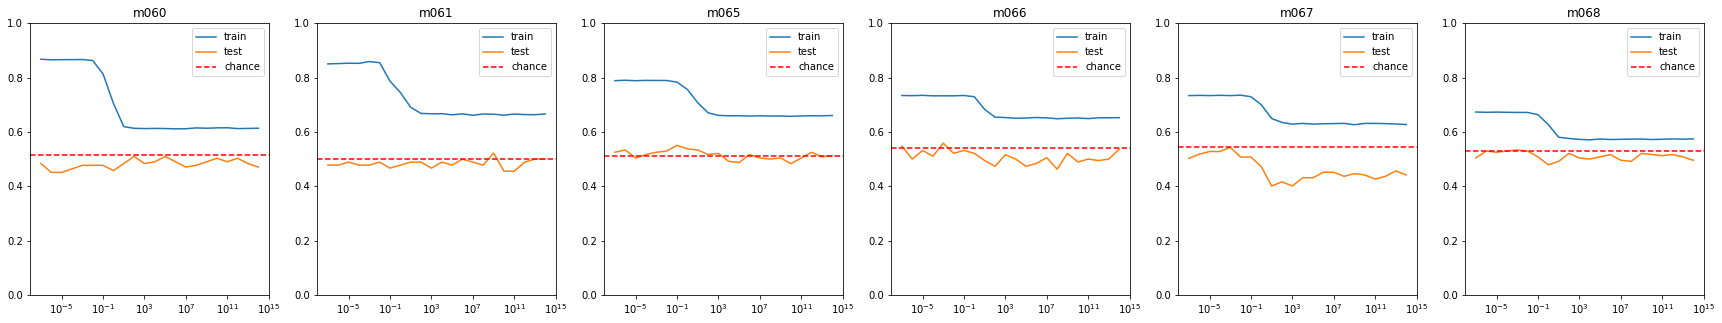

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)
Doing mouse m065
shapes (122, 415) (116, 415)
Doing mouse m066
shapes (86, 235) (102, 235)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)
Doing mouse m068
shapes (126, 140) (112, 140)


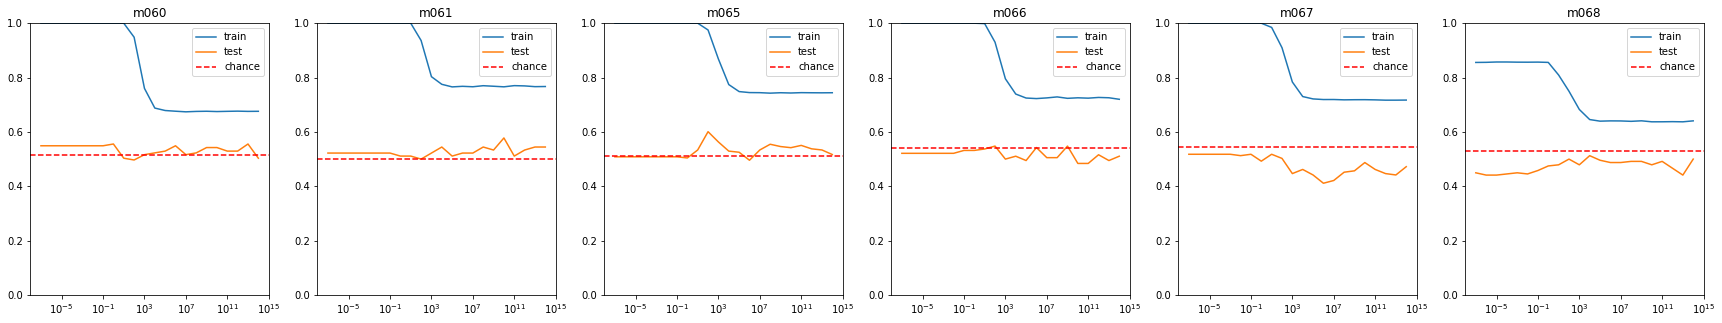

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


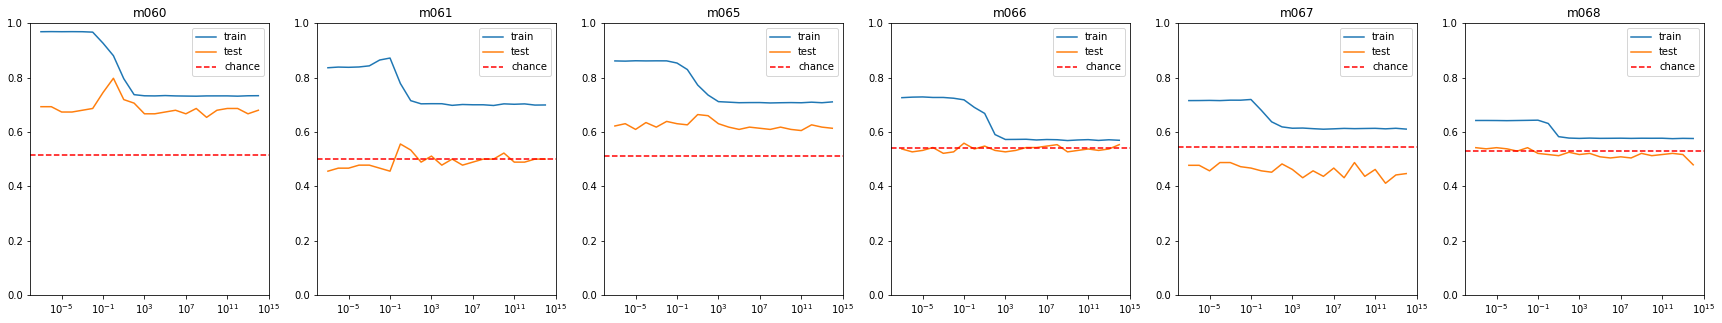

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)
Doing mouse m065
shapes (122, 415) (116, 415)
Doing mouse m066
shapes (86, 235) (102, 235)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)
Doing mouse m068
shapes (126, 140) (112, 140)


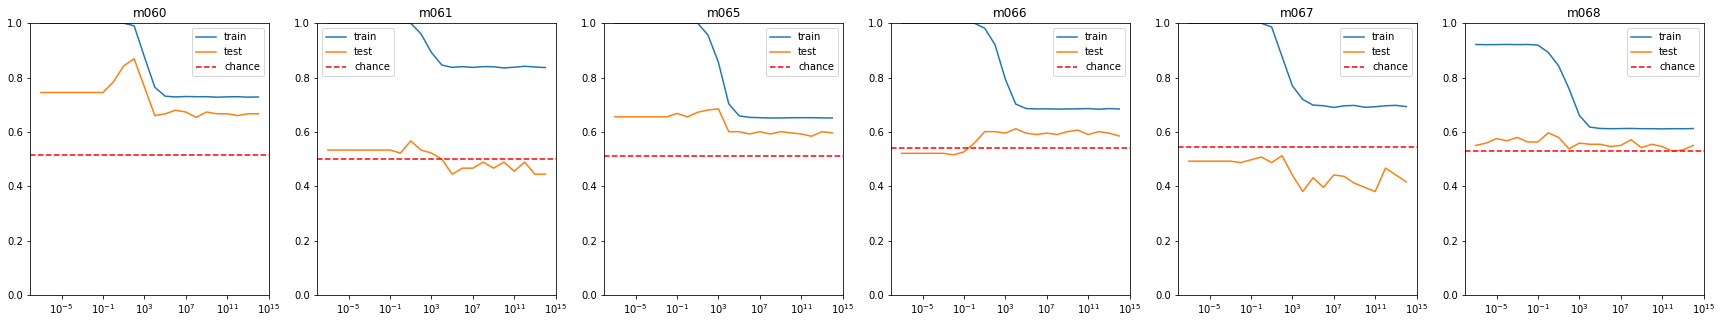

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


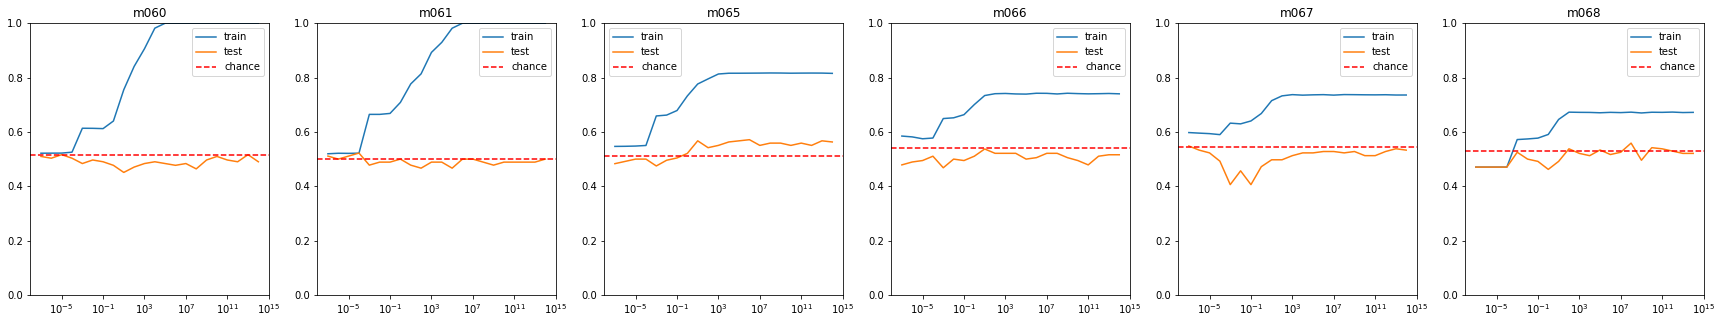

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)
Doing mouse m065
shapes (122, 415) (116, 415)
Doing mouse m066
shapes (86, 235) (102, 235)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)
Doing mouse m068
shapes (126, 140) (112, 140)


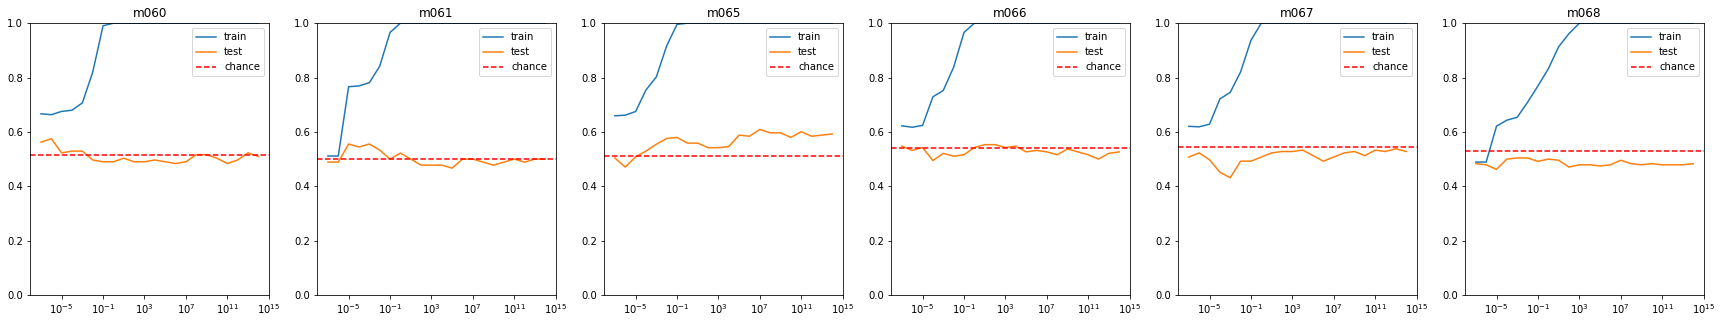

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


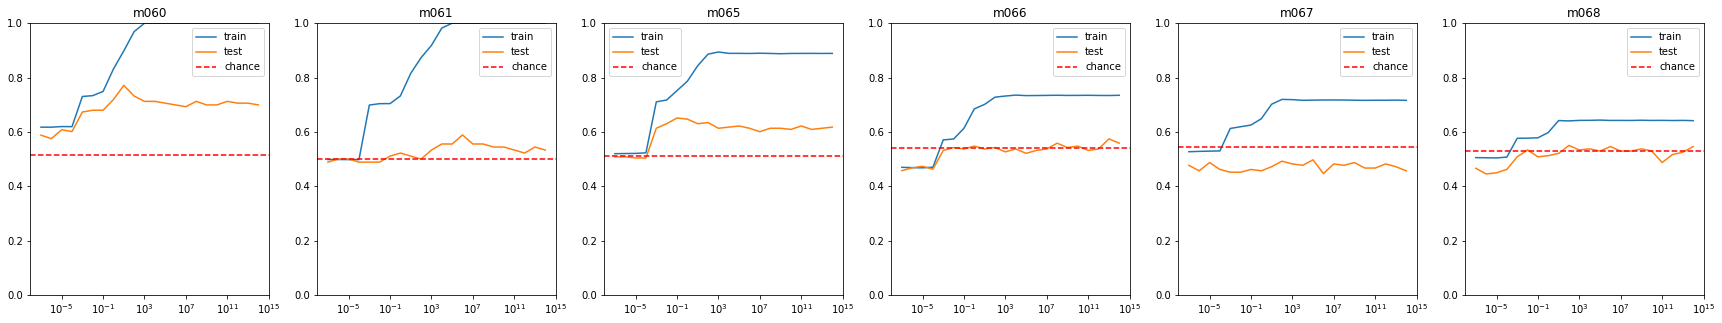

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)
Doing mouse m065
shapes (122, 415) (116, 415)
Doing mouse m066
shapes (86, 235) (102, 235)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)
Doing mouse m068
shapes (126, 140) (112, 140)


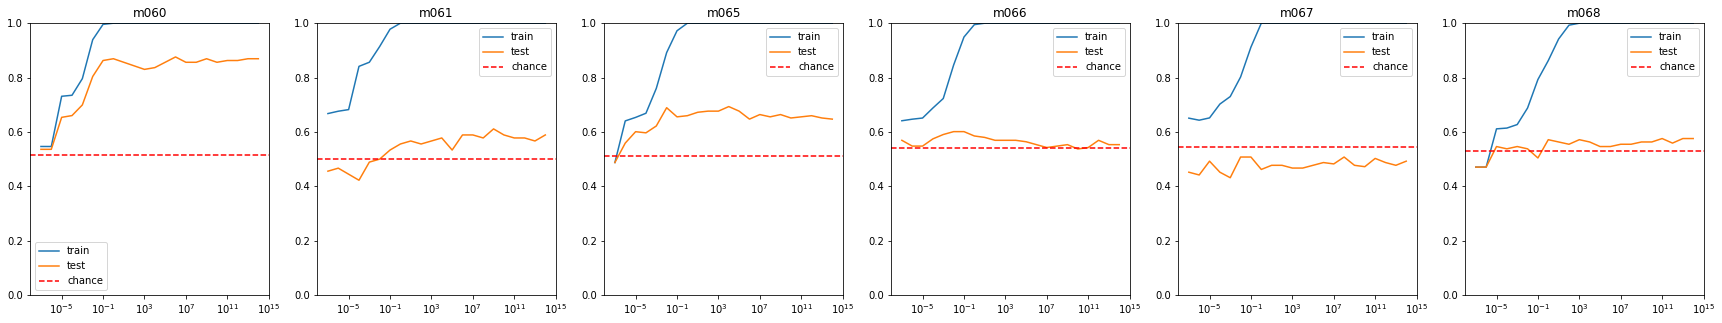

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


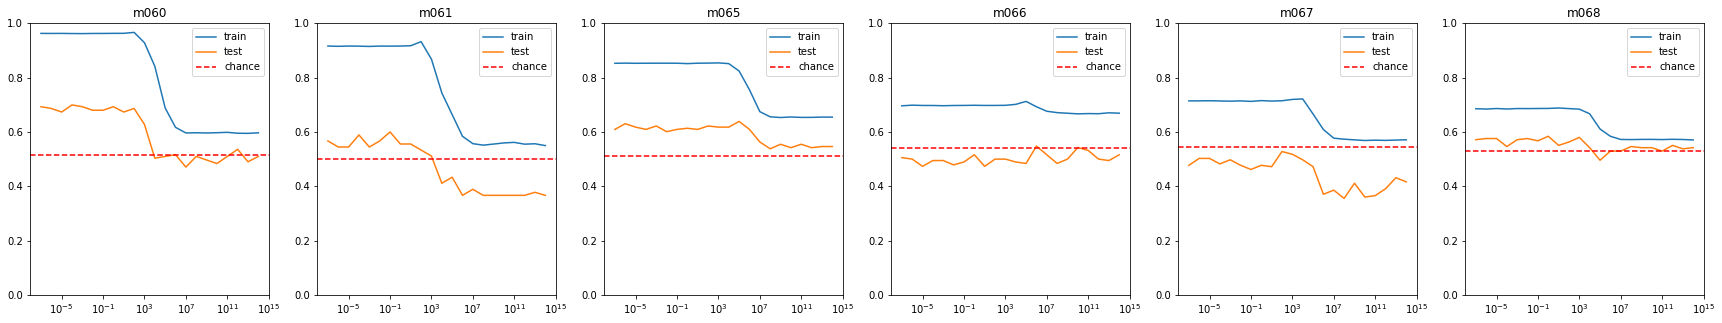

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.0665e-16): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.09978e-16): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.08238e-16): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.07949e-16): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.07516e-16): result may not be accurate.
  overwrite_a=Fal

Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.09091e-16): result may not be accurate.
  overwrite_a=False)


Doing mouse m065
shapes (122, 415) (116, 415)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.98813e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.02242e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.89589e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.9619e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.93251e-17): result may not be accurate.
  overwrite_a=Fal

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.90756e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.90717e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.91969e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.91117e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.84969e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.96302e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.92557e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.80157e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.91031e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.9379e-17): result may not be accurate.
  overwrite_a=Fal

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.87659e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.84004e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.96989e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.05016e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.98413e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.78132e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.89261e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.99287e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.88997e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.05702e-17): result may not be accurate.
  overwrite_a=Fa

Doing mouse m066
shapes (86, 235) (102, 235)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.35894e-18): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.48736e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.53452e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.57762e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.57023e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.54584e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.45312e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.39108e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.57425e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.64636e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.66309e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.37544e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.48625e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.47737e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.4692e-17): result may not be accurate.
  overwrite_a=Fal

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.33746e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.63765e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.61115e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.58396e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.50367e-17): result may not be accurate.
  overwrite_a=Fa

Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.83123e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.41222e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.44053e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.55845e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.5359e-17): result may not be accurate.
  overwrite_a=Fal

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.54192e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.31714e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.28685e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.41447e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.55274e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.08831e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.46351e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.65656e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.03127e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.48869e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.60038e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.10676e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.59011e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.56652e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.59576e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.84599e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.8157e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.11317e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.93362e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.52975e-17): result may not be accurate.
  overwrite_a=Fal

Doing mouse m068
shapes (126, 140) (112, 140)


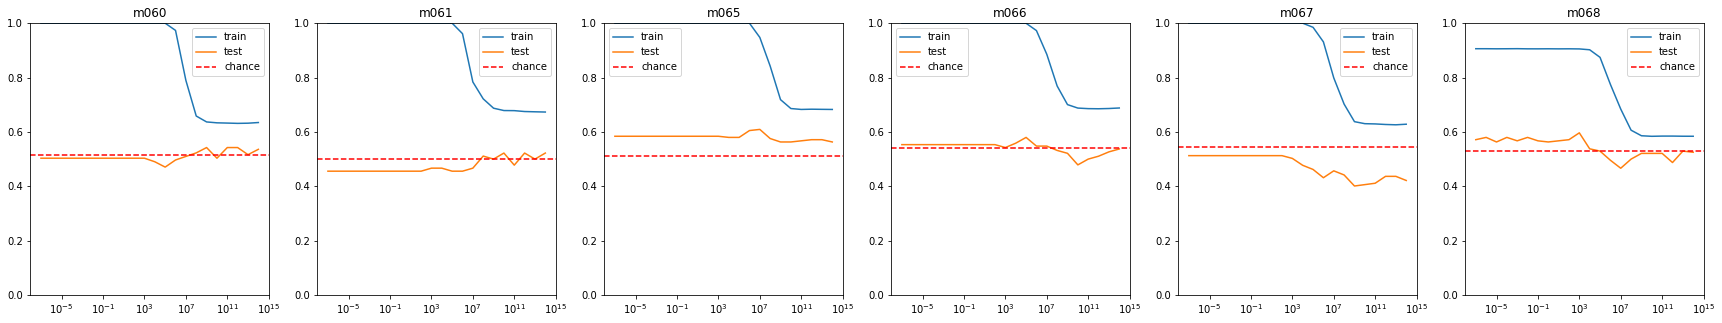

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)
Doing mouse m066
shapes (86, 47) (102, 47)
Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 49) (107, 49)
Doing mouse m068
shapes (126, 28) (112, 28)


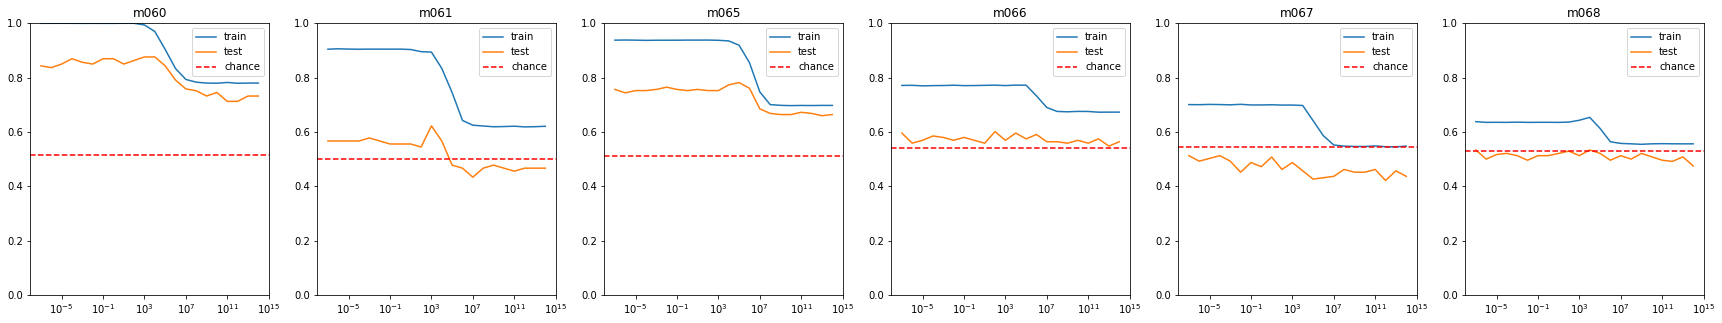

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 440) (74, 440)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 230) (45, 230)
Doing mouse m065
shapes (122, 415) (116, 415)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.1976e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.26495e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.28411e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.28009e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.1891e-17): result may not be accurate.
  overwrite_a=Fals

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.33433e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.28044e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.30081e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.23998e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.36576e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.14033e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.28694e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.21175e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.25334e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.20121e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.29235e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.20384e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.20306e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.25392e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.19807e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.2483e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.25966e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.31071e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.202e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.24253e-17): result may not be accurate.
  overwrite_a=False

Doing mouse m066
shapes (86, 235) (102, 235)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.04666e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.30471e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.33079e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.25916e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.28617e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.19676e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.42078e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.04869e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.45575e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.5938e-17): result may not be accurate.
  overwrite_a=Fal

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.32232e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.51845e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.00065e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.40064e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.64031e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.07226e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.1271e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.88908e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.34463e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.43812e-17): result may not be accurate.
  overwrite_a=Fal

Doing mouse m067
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm067_20200203'} ; skipping
shapes (90, 245) (107, 245)


/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.52945e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.7655e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.5329e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.80142e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.09276e-17): result may not be accurate.
  overwrite_a=Fals

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.98886e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.24634e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.93168e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.71751e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.71854e-17): result may not be accurate.
  overwrite_a=Fa

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.9215e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.6262e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.99802e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.32492e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.87877e-17): result may not be accurate.
  overwrite_a=Fals

/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.80828e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.83508e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.87869e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.13681e-17): result may not be accurate.
  overwrite_a=False)
/opt/anaconda3/envs/py36nest/lib/python3.6/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.56868e-17): result may not be accurate.
  overwrite_a=Fa

Doing mouse m068
shapes (126, 140) (112, 140)


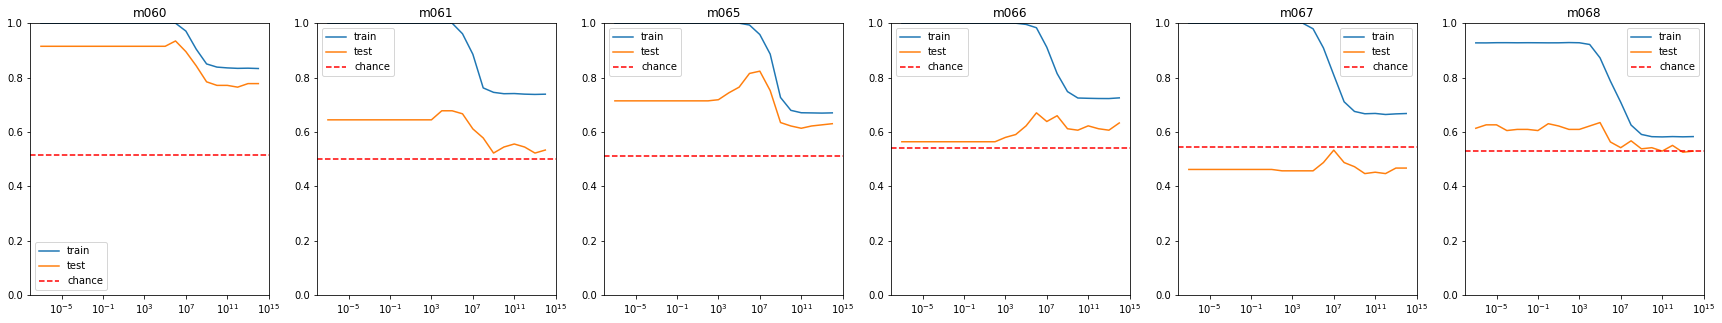

Doing mouse m060
No behaviour found for {'direction': 'L', 'performance': 'Mistake', 'session': 'm060_20190606'} ; skipping
shapes (79, 88) (74, 88)
Doing mouse m061
No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
Doing mouse m065
shapes (122, 83) (116, 83)


KeyboardInterrupt: 

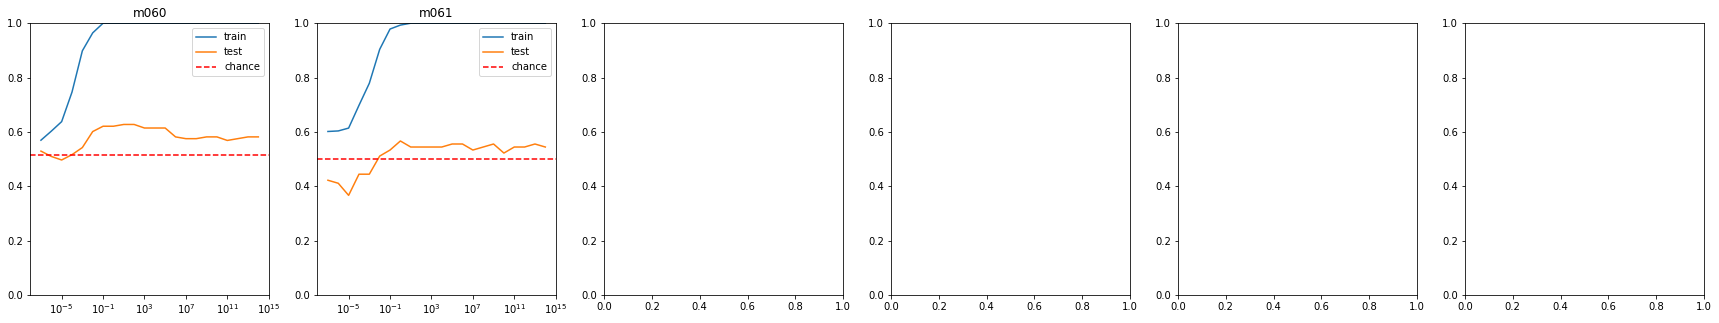

In [7]:
for datatype in ['deconv', 'raw']:
    for classifierName in ['LinL2', 'LogL2']:#, 'MPLL2']:
    #     for interval in [8, 7, 6]:
        for semiphase in ['M2', 'M1']:
            for metricName in ['mean', 'temporal_basis']:
    #             cross_validate(dataDB, 'deconv', {'interval' : interval}, metricName, classifierName)
                cross_validate(dataDB, datatype, {'semiphase' : semiphase}, metricName, classifierName)

In [39]:
queryDictL = {'datatype' : 'deconv', 'mousename' : 'm061', 'direction' : 'L'}
queryDictR = {'datatype' : 'deconv', 'mousename' : 'm061', 'direction' : 'R'}

dataL = metric_by_selector(dataDB, queryDictL, 'mean', 'rp', {'semiphase' : 'M2'}, {})
dataR = metric_by_selector(dataDB, queryDictR, 'mean', 'rp', {'semiphase' : 'M2'}, {})

dataL = numpy_merge_dimensions(dataL, 1, 3)
dataR = numpy_merge_dimensions(dataR, 1, 3)

print('shapes', dataL.shape, dataR.shape)

classifier = get_classifier('LinL2', 1.0E+7)
rez = binary_classifier(dataL, dataR, classifier, havePVal=True, method='looc')

print(rez)

No behaviour found for {'direction': 'R', 'performance': 'Mistake', 'session': 'm061_20190517'} ; skipping
shapes (45, 46) (45, 46)
cmTrain
 [[2025 1980]
 [1980 2025]]
cmTest
 [[ 0 45]
 [45  0]]
{'accTrain': 0.5056179775280899, 'accTest': 0.0, 'accNaive': 0.5, 'pval': 1.0}


In [ ]:
# 4B
queryDict = {"direction": "L", "datatype": "raw"}
#queryDict = {"performance": "Correct", "datatype": "raw"}
settings = {"serial": True, "metricSettings": None}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

rez = plots_lib.table_binary_classification(dataDB, "Maintenance", "performance", "cumul_ord_coeff", "",
                                            queryDict, settings)

rez

In [ ]:
# 4A
queryDict = {"performance": "Correct", "datatype": "raw"}
#queryDict = {"direction": "L", "datatype": "high"}
settings = {"serial": True, "metricSettings": {"lag" : 1, "max_lag" : 3}}
#settings = {"serial" : True, "metricSettings" : {"metric" : num_non_zero_std}}

plots_lib.table_binary_classification_bymouse(dataDB, "Maintenance", "direction", "temporal_basis", "rp",
                                              queryDict, settings)